In [34]:
# Reference:
# https://www.kaggle.com/defeater/importance-of-a-linguistic-pre-processing

In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
lemmer = WordNetLemmatizer()

In [2]:
print(stemmer.stem('dictionaries'))
print(lemmer.lemmatize('dictionaries'))

dict
dictionary


In [4]:
from gensim import models
import numpy as np
from pandas import DataFrame, Series
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
stop = stopwords.words('english')
alpha_tokenizer = RegexpTokenizer('[A-Za-z]\w+')

In [6]:
from subprocess import check_output
print(check_output(['ls', './../data']).decode('utf8'))

GoogleNews-vectors-negative300.bin
test.csv
train.csv



In [7]:
df_train = DataFrame.from_csv('./../data/train.csv').dropna()

In [8]:
texts = np.concatenate([df_train.question1.values, df_train.question2.values])

In [9]:
def process_sent(words, lemmatize=False, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    for index, word in enumerate(tokens):
        if lemmatize:
            tokens[index] = lemmer.lemmatize(word)
        elif stem:
            tokens[index] = stemmer.stem(word)
        else:
            tokens[index] = word
    return tokens

In [10]:
corpus_lemmatized = [process_sent(sent, lemmatize=True, stem=False) for sent in texts]

In [11]:
corpus_stemmed = [process_sent(sent, lemmatize=False, stem=True) for sent in texts]

In [13]:
corpus = [process_sent(sent) for sent in texts]

In [14]:
VECTOR_SIZE = 100
min_count = 10
size = VECTOR_SIZE
window = 10

In [16]:
model_lemmatized = models.Word2Vec(corpus_lemmatized, min_count=min_count, size=size, window=window)

In [17]:
model_stemmed = models.Word2Vec(corpus_stemmed, min_count=min_count, size=size, window=window)

In [18]:
model = models.Word2Vec(corpus, min_count=min_count, size=size, window=window)

In [19]:
model_lemmatized.most_similar('playstation')

[('ps4', 0.8376371264457703),
 ('console', 0.7802705764770508),
 ('pirated', 0.7593536376953125),
 ('ps3', 0.7558519244194031),
 ('xbox', 0.7534470558166504),
 ('gta', 0.7508143186569214),
 ('wii', 0.7190563678741455),
 ('mod', 0.7184896469116211),
 ('geforce', 0.6762281060218811),
 ('fifa', 0.662062406539917)]

In [20]:
q1 = df_train.question1.values
q2 = df_train.question2.values
Y = np.array(df_train.is_duplicate.values)

In [28]:
def preprocess_check(words, lemmatize=False, stem=False):
    words = words.lower()
    tokens = alpha_tokenizer.tokenize(words)
    model_tokens = []
    for index, word in enumerate(tokens):
        if lemmatize:
            lem_word = lemmer.lemmatize(word)
            if lem_word in model_lemmatized.wv.vocab:
                model_tokens.append(lem_word)
        elif stem:
            stem_word = stemmer.stem(word)
            if stem_word in model_stemmed.wv.vocab:
                model_tokens.append(stem_word)
        else:
            if word in model.wv.vocab:
                model_tokens.append(word)
    return model_tokens

In [29]:
old_err_state = np.seterr(all='raise')

def vectorize(words, words_2, model, num_features, lemmatize=False, stem=False):
    features = np.zeros((num_features), dtype='float32')
    words_amount = 0
    
    words = preprocess_check(words, lemmatize, stem)
    words_2 = preprocess_check(words_2, lemmatize, stem)
    for word in words:
        words_amount = words_amount + 1
        features = np.add(features, model[word])
    for word in words_2:
        words_amount = words_amount + 1
        features = np.add(features, words_amount)
    try:
        features = np.divide(features, words_amount)
    except FloatingPointError:
        features = np.zeros(num_features, dtype='float32')
    return features

In [26]:
X_lem = []
for index, sentence in enumerate(q1):
    X_lem.append(vectorize(sentence, q2[index], model_lemmatized, VECTOR_SIZE, True, False))
X_lem = np.array(X_lem)

In [30]:
X_stem = []
for index, sentence in enumerate(q1):
    X_stem.append(vectorize(sentence, q2[index], model_stemmed, VECTOR_SIZE, False, True))
X_stem = np.array(X_stem)

In [31]:
X = []
for index, sentence in enumerate(q1):
    X.append(vectorize(sentence, q2[index], model, VECTOR_SIZE))
X = np.array(X)

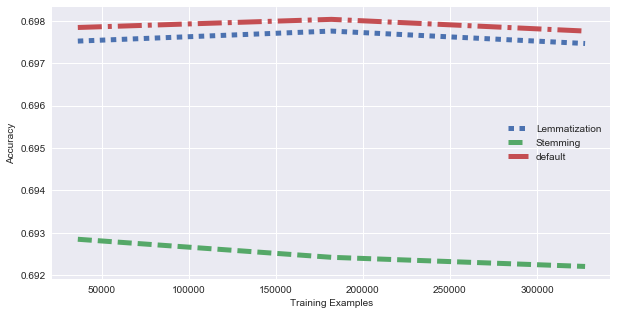

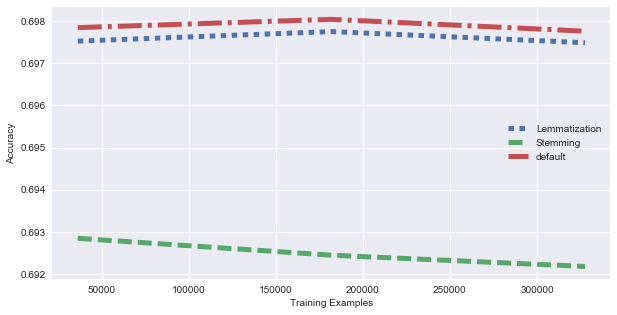

In [33]:
results = []
title_font = {'size': '10', 'color': 'black', 'weight': 'normal', 'verticalalignment': 'bottom'}
axis_font = {'size': '10'}
plt.figure(figsize=(10, 5))
plt.xlabel('Training Examples', **axis_font)
plt.ylabel('Accuracy', **axis_font)
plt.tick_params(labelsize=10)
for X_set, name, lstyle in [(X_lem, 'Lemmatization', 'dotted'),
                           (X_stem, 'Stemming', 'dashed'),
                           (X, 'default', 'dashdot')
                           ]:
    estimator = LogisticRegression(C=1)
    cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=0)
    train_sizes = np.linspace(0.1, 0.9, 3)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_set, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    results.append({'preprocessing': name, 'score': train_scores_mean[-1]})
    plt.plot(train_sizes, train_scores_mean, label=name, linewidth=5, linestyle=lstyle)
plt.legend(loc='best')
plt.show()

In [ ]:
clf = LogisticRegression(C = 1)
clf.fit(X, Y)

df_test = DataFrame.from_csv('./../data/test.csv').fillna('None')
# q1 = df_train.question1.values[:100]
# q2 = df_train.question2.values[:100]
q1 = df_test.question1.values
q2 = df_test.question2.values

X_test = []
for index, sentence in enumerate(q1):
    X_test.append(vectorize(sentence, q2[index], model, VECTOR_SIZE))
X_test = np.array(X_test)

result = clf.predict(X_test)

In [38]:
sub = DataFrame()
sub['test_id'] = [i for i in range(len(result))]
sub['is_duplicate'] = result
sub.to_csv('submission.csv', index=False)